In [1]:
import pandas as pd
import plotly.express as px
import torch.nn.functional as F

In [2]:
import torch

In [3]:
import numpy as np

In [4]:
import re
import random
random.seed(42)

## 0. Number of Free Parameters

In [5]:
V = 11228
n = 6

m = 100
h = 60

V * (1 + n*m + h) + h * (1 + (n-1)*m)

7451768

## 0. Context

The aim of the notebook is to replicate NNLM (`Neural Network Language Model`) by Bengio et al. 

**Objective**

1. Nth word, given n-1 words in sequence
2. Understand how word feature looks like for similar words like cat, dog


**Assumption**

1. Word prediction is happening within a sentence, this implies `.` acts as `End of Sentence` Token

## 1. Downloading Data

In [6]:
from nltk.corpus import brown

## 2. Creating Data Set from `brown` corpus


> Total Sentences is 57340, and each sentences will be taken as stand alone unit for creating input-target pair 

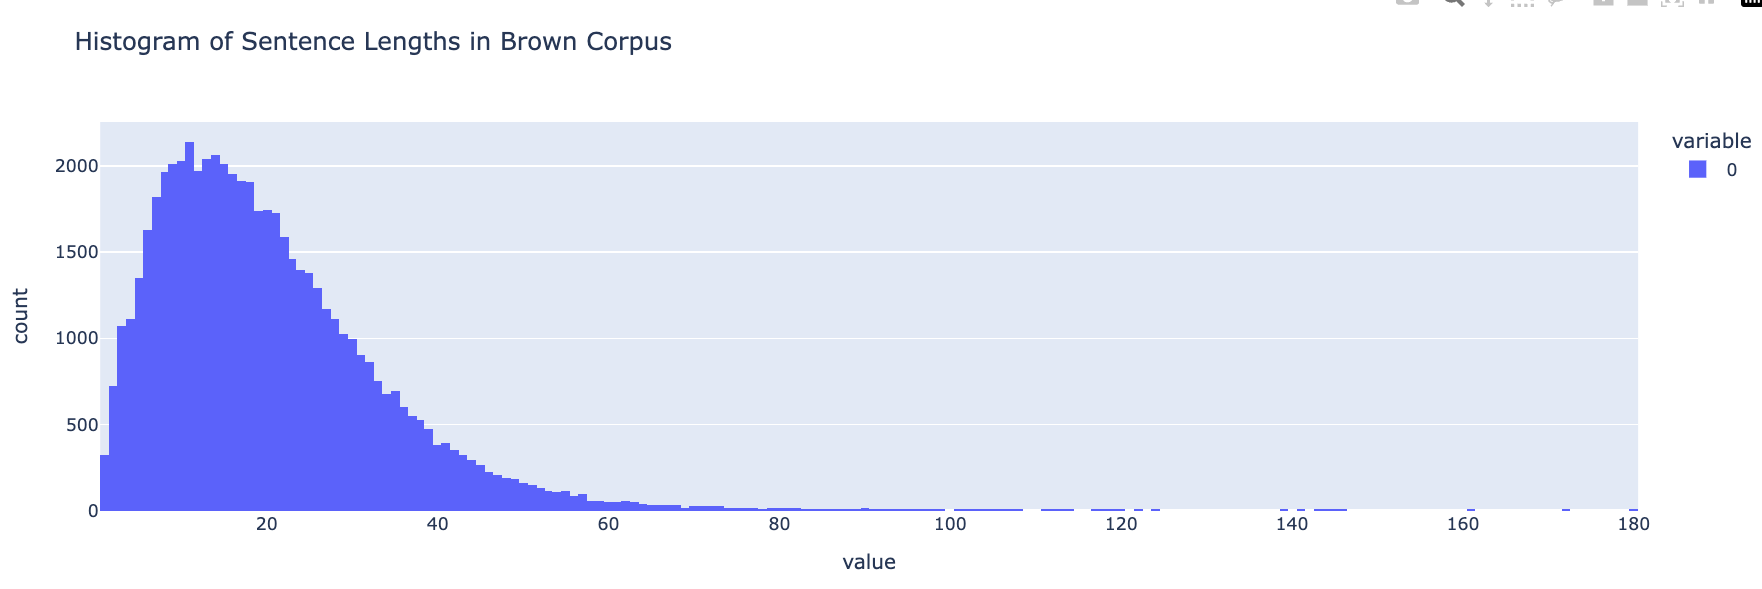

input context block : 4

Minimum sentence length: 5

### 2.1 Creating sentence split for train, test, validatiom

In [7]:
sentence_list_selected = [sent for sent in brown.sents() if len(sent) > 4]

In [8]:
len(sentence_list_selected)

54105

In [9]:
random.shuffle(sentence_list_selected)
n1 = int(0.8 * len(sentence_list_selected))
n2 = int(0.9 *len(sentence_list_selected))

train_sentences = sentence_list_selected[:n1]
validation_sentences = sentence_list_selected[n1:n2]
test_sentences = sentence_list_selected[n2:]

### 2.1. Creating Train, Validation & Test Corpus

No Special Preprocessing is being applied except from case folding

In [10]:
training_corpus = {}

for sent in train_sentences:
    for word in sent:
        training_corpus[word.lower()] = training_corpus.get(word.lower(),0) + 1

In [11]:
print(f"Vocabulary size in Training Split: {len(training_corpus.items())}")

Vocabulary size in Training Split: 44898


### 2.2. Distribution of Tokens in Training Corpus

In [12]:
df_word_count = pd.DataFrame(data=sorted(training_corpus.items(), key= lambda kv: -kv[1]), columns=['Word', 'Count'])

In [13]:
px.histogram(df_word_count, x='Count', nbins=8000, title='Word Count Distribution in Training Split')

In [14]:
## based on paper, words appearing >= 3 times are considered as part of the vocabulary

vocabulary = [word for word, count in training_corpus.items() if count >= 5]

### 2.3. Creating encoder

In [15]:
encoder = {word: ix for ix, word in enumerate(vocabulary)}

_TOKEN_OOV_ = "<|UNK|>"

encoder[_TOKEN_OOV_] = len(encoder)

#### 2.4. Understanding Presence of Special Characters

In [16]:
special_chars = set()
for word in vocabulary:
    special_chars.update(re.findall(r'[^a-zA-Z0-9]', word))

print("Unique special characters:", special_chars)

Unique special characters: {"'", '(', '.', ',', '*', '{', ':', '?', ')', '%', '`', '}', ';', '-', '&', '/', '!', '$'}


In [17]:
def special_char_vocab(vocabulary: list[str], special_char: str) -> list[str]:
    return [word for word in vocabulary if special_char in word]

In [18]:
req_data = []
for char in special_chars:
    use_words = special_char_vocab(vocabulary, char)
    for word in use_words:
        req_data.append((char, word))

df_special_chars_use = pd.DataFrame(data=req_data, columns=['Special Character', 'Word'])

### 2.4. Creating Decoder

In [21]:
decoder = {ix: word for word, ix in encoder.items()}

In [22]:
decoder[11956]

'discomfort'

### 2.5 Implementing Simple Tokeniser

No Text splitting is done as data provided has already splitted it

In [23]:
class Tokenizer:
    _TOKEN_OOV_ = "<|UNK|>"

    def __init__(self, encoder: dict):
        self.str_to_int = encoder
        self.int_to_str = {i: s for s, i in encoder.items()}


    def encode(self, text_list: list[str]) -> list[int]:

        text_lower = [word.lower() for word in text_list if word.strip()] # case folding and removing spaces


        return [self.str_to_int.get(word, self.str_to_int[_TOKEN_OOV_]) for word in text_lower]
    
    def decode(self, text: list[int]) -> str:
        return ' '.join([self.int_to_str.get(ix) for ix in text]) # decoding


In [24]:
tokenizer = Tokenizer(encoder)

In [25]:
word_list = train_sentences[41]
tokenizer.decode(tokenizer.encode(word_list))

"`` he looks as feminine as you can imagine '' , she decided ."

### 3. Data set creation

In [26]:
random_sample_sentences = random.sample(train_sentences, 20)

### Checking if full stop occurs at the end of the sentence
req_list = []
for sentence_split in random_sample_sentences:
    length = len(sentence_split)
    for idx, token in enumerate(sentence_split):
        if token == ".":
            req_list.append((length -1, idx))

df_check = pd.DataFrame(data=req_list, columns=['Length', 'Index'])

In [27]:
context_size = 4

In [28]:
def create_input_target_pair(word_list: list[str], tokeniser: Tokenizer ,context_size: int) -> tuple[list[int], list[int]]:
    x = []
    y = []

    k = 0

    _WORD_COUNT_ = len(word_list)

    for k in range(_WORD_COUNT_ - context_size):
        input_word_list = word_list[k : k + context_size]
        target_word = word_list[k + context_size]

        x.append(tokeniser.encode(input_word_list))
        y.append(tokeniser.encode([target_word])[0])
        

    return x, y

In [29]:
## Creating Train Set, for Testing Out 
x = []
y = []

stride = 1

for sentence_split in train_sentences[0:2]:
    k = 0
    for k in range(len(sentence_split) - context_size):
        context_broken_sent = sentence_split[k  : k  + context_size]
        output_token = sentence_split[k + context_size]
        
        x.append(tokenizer.encode(context_broken_sent))
        y.append(tokenizer.encode([output_token])[0])


X = torch.tensor(x)
Y = torch.tensor(y)

#### 3.1. Validating DataSet Creation

In [30]:
print("Input", "-->","Output")
print("---------------------------------------")

for input, output in zip(x,y):
    print(tokenizer.decode(input), "-->",tokenizer.decode([output]))

Input --> Output
---------------------------------------
he <|UNK|> his left --> shoulder
<|UNK|> his left shoulder --> into
his left shoulder into --> it
left shoulder into it --> and
shoulder into it and --> slashed
into it and slashed --> at
it and slashed at --> roberts'
and slashed at roberts' --> <|UNK|>
slashed at roberts' <|UNK|> --> with
at roberts' <|UNK|> with --> his
roberts' <|UNK|> with his --> own
<|UNK|> with his own --> ,
with his own , --> felt
his own , felt --> the
own , felt the --> blade
, felt the blade --> slide
felt the blade slide --> off
the blade slide off --> his
blade slide off his --> sleeve
slide off his sleeve --> .
i wish to make --> jesus
wish to make jesus --> an
to make jesus an --> authentic
make jesus an authentic --> jew
jesus an authentic jew --> .


#### 3.2. Creating Training , Validation & Test Set

In [ ]:
len(test_sentences)

In [31]:
x_tr = []
y_tr = []

for sentence_split in train_sentences:
    x, y = create_input_target_pair(sentence_split, tokenizer, context_size)
    x_tr.extend(x)
    y_tr.extend(y)

X_trn = torch.tensor(x_tr)
Y_trn = torch.tensor(y_tr)

x_val = []
y_val = []

for sentence_split in validation_sentences:
    x, y = create_input_target_pair(sentence_split, tokenizer, context_size)
    x_val.extend(x)
    y_val.extend(y)

X_val = torch.tensor(x_val)
Y_val = torch.tensor(y_val)

x_test = []
y_test = []

for sentence_split in test_sentences:
    x, y = create_input_target_pair(sentence_split, tokenizer, context_size)
    x_test.extend(x)
    y_test.extend(y)

X_test = torch.tensor(x_test)
Y_test = torch.tensor(y_test)

In [32]:
print("Train Set Size:", X_trn.size())
print("Validation Set Size:", X_val.size())
print("Test Set Size:", X_test.size())

Train Set Size: torch.Size([749619, 4])
Validation Set Size: torch.Size([93541, 4])
Test Set Size: torch.Size([92184, 4])


#### 3.3. Sample Forward and BackPropagation

In [33]:
x_samp = []
y_samp = []

for sentence_split in train_sentences[0:2]:
    x, y = create_input_target_pair(sentence_split, tokenizer, context_size)
    x_samp.extend(x)
    y_samp.extend(y)

X_samp = torch.tensor(x_samp)
Y_samp = torch.tensor(y_samp)

In [34]:
Y_samp.shape

torch.Size([25])

In [35]:
X_ = X_samp.to("mps")
Y_ = Y_samp.to("mps")

In [36]:
C = torch.randn(size=(len(encoder), m), requires_grad=True, device="mps") ## Feature Vectors Lookup Table

W1 = torch.randn(size=(m * context_size, h), requires_grad=True,device="mps") ## Hidden Layer to Output Layer
b1 = torch.randn(h, requires_grad=True, device="mps")

W2 = torch.randn(size=(h, len(encoder)), requires_grad=True, device="mps") ## Output Layer to Vocabulary
b2 = torch.randn(len(encoder), requires_grad=True, device="mps")

parameters = [C, W1, b1, W2, b2]

In [37]:
sum(p.nelement() for p in parameters)

2003072

In [102]:
## forward pass ##

emb = C[X_] ## Embedding Layer (20, 4, 100)

hs = torch.tanh(emb.view(len(X_), context_size * m ) @ W1 + b1) ## Hidden Layer (20 , 4 * 100)

logits = hs @ W2 + b2 ## Output Layer (20 * 4, 11957) ## Log-Counts

counts = torch.exp(logits) ## Counts

loss = F.cross_entropy(logits,Y_)

# Backward pass 

for p in parameters:
    p.grad = None

loss.backward()

for p in parameters: 
        p.data += - 1 * p.grad

In [103]:
logits, Y_

(tensor([[ -1.3673,  21.1820,  -1.5390,  ...,   4.2788,   5.1629, -11.5901],
         [ 10.8850,   8.4407,  10.2217,  ...,  -4.5426,  11.6979,  -9.9957],
         [  2.4186,  -1.7465,  -7.4232,  ...,  -7.5384,   7.9702,  -5.8416],
         ...,
         [ 12.6064,  19.2248,  -1.7415,  ...,   2.0799,  -6.2575, -10.8585],
         [  4.5444,  -1.6555,  -9.9174,  ...,  12.9518,   3.3414,   9.5914],
         [-15.2080, -12.7763,   2.9646,  ...,   3.6942, -11.2621,  10.1684]],
        device='mps:0', grad_fn=<AddBackward0>),
 tensor([    3,     4,     5,     6,     7,     8,     9, 12291,    10,     1,
            11,    12,    13,    14,    15,    16,    17,     1,    18,    19,
            24,    25,    26,    27,    19], device='mps:0'))

#### 3.4. Estimating Right Learning Rate

In [105]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [106]:
lri = []
lossi = []

lrp = []

X_trn = X_trn.to("mps")
Y_trn = Y_trn.to("mps")


for i in range(1000):

    ## Minibatch Gradient Descent ##
    ix = torch.randint(0, X_trn.shape[0], (128,))

    ## Forward Pass ##
    emb = C[X_trn[ix]]

    hs = torch.tanh(emb.view(len(ix), context_size * m) @ W1 + b1)

    logits = hs @ W2 + b2

    loss = F.cross_entropy(logits, Y_trn[ix])

    for p in parameters:
        p.grad = None

    loss.backward()

    ## Update ##
    lr = lrs[i]

    for p in parameters:
        p.data += - lr * p.grad

    lri.append(lre[i].item())
    lrp.append(lr.item())
    lossi.append(loss.item())


In [107]:
import matplotlib.pyplot as plt 
%matplotlib inline 

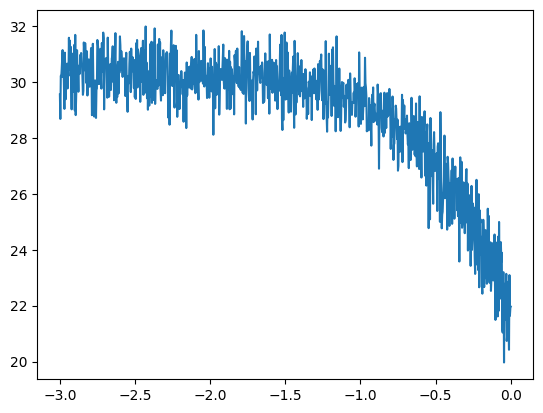

In [108]:
plt.plot(lri, lossi)

Good Learning Rate Seems to be around $10^{-1.5}$ to $10^{-1}$

Does it seems logical?

#### 3.5. Performing Batch Gradient Descent

In [109]:
from tqdm.notebook import tqdm

In [252]:
m = 30
h = 50
device = "mps"

g = torch.Generator(device=device).manual_seed(217483647)
C = torch.randn(size=(len(encoder), m), requires_grad=True, device=device, generator=g) ## Feature Vectors Lookup Table

W1 = torch.randn(size=(m * context_size, h), requires_grad=True,device=device, generator=g) ## Hidden Layer to Output Layer
b1 = torch.randn(h, requires_grad=True, device=device, generator=g)

WW = torch.randn(size=(m * context_size, len(encoder)), requires_grad=True, device=device, generator=g)

W2 = torch.randn(size=(h, len(encoder)), requires_grad=True, device=device, generator=g) ## Output Layer to Vocabulary
b2 = torch.randn(len(encoder), requires_grad=True, device=device, generator=g)

parameters = [C, WW,W1, b1, W2, b2]

In [253]:
sum(p.nelement() for p in parameters)

2476742

In [254]:
1024 * 3

3072

In [256]:
X_trn = X_trn.to(device=device)
Y_trn = Y_trn.to(device=device)

X_val = X_val.to(device=device)
Y_val = Y_val.to(device=device)

In [257]:
import torch.nn as nn


In [291]:
_SAMPLE_COUNT_ = X_trn.shape[0]
_BATCH_SIZE_ = 2048

indices = torch.randperm(_SAMPLE_COUNT_)

indices_val = torch.randperm(X_val.shape[0])

mini_batches = [(indices[i : i + _BATCH_SIZE_]) for i in range(0, _SAMPLE_COUNT_, _BATCH_SIZE_)]
mini_batches_val = [(indices_val[i : i + _BATCH_SIZE_]) for i in range(0, len(X_val), _BATCH_SIZE_)]



# loss_epoch = []
# loss_val = []

for i in tqdm(range(60), desc="Epochs"):
    loss_mini_batch_trn = []

    loss_mini_batch_val = []

    for mini_b in mini_batches_val:
        with torch.no_grad():
            ix = mini_b
            emb = C[X_val[ix]]
            hs = torch.tanh(emb.view(len(ix), context_size * m) @ W1 + b1)
            logits = hs @ W2 + b2 + emb.view(len(ix), context_size * m) @ WW
            loss_val_b = F.cross_entropy(logits, Y_val[ix])
            loss_mini_batch_val.append(loss_val_b.item())
    
    for mini_batch_idx in mini_batches:
        
        ix = mini_batch_idx

        emb = C[X_trn[ix]]

        hs = torch.tanh(emb.view(len(ix), context_size * m) @ W1 + b1)

        logits = hs @ W2 + b2 + emb.view(len(ix), context_size * m) @ WW

        loss = F.cross_entropy(logits, Y_trn[ix])

        loss_mini_batch_trn.append(loss.item())

        for p in parameters:
            p.grad = None

        loss.backward()

        for p in parameters:
            p.data += - 0.1 * p.grad
    
    loss_val.append(np.mean(loss_mini_batch_val))
    loss_epoch.append(np.mean(loss_mini_batch_trn))

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

In [292]:
(logits[0] == logits[1])

tensor([False, False, False,  ..., False, False, False], device='mps:0')

In [293]:
W2.grad

tensor([[-1.4922e-02, -3.2692e-02,  1.7139e-04,  ...,  2.8938e-09,
          3.0200e-15,  1.6179e-02],
        [-1.4922e-02, -3.2692e-02,  1.7139e-04,  ...,  2.8938e-09,
          3.0200e-15,  1.6179e-02],
        [-1.4922e-02, -3.2692e-02,  1.7139e-04,  ...,  2.8938e-09,
          3.0195e-15,  1.6174e-02],
        ...,
        [-1.4922e-02, -3.2692e-02,  1.7139e-04,  ...,  2.8938e-09,
          3.0200e-15,  1.6179e-02],
        [-1.4922e-02, -3.2692e-02,  1.7139e-04,  ...,  2.8938e-09,
          3.0200e-15,  1.6179e-02],
        [-1.4922e-02, -3.2692e-02,  1.7139e-04,  ...,  2.8938e-09,
          3.0200e-15,  1.6179e-02]], device='mps:0')

In [294]:
hs[0]

tensor([ 1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000,
         1.0000, -1.0000,  0.6448,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         1.0000,  1.0000, -1.0000,  0.9999,  1.0000, -1.0000,  1.0000, -1.0000,
         1.0000,  1.0000, -1.0000, -0.0501,  1.0000, -1.0000,  1.0000,  1.0000,
         1.0000, -0.9665, -1.0000, -1.0000,  1.0000, -1.0000, -0.3523,  1.0000,
        -1.0000,  1.0000, -1.0000,  0.9825,  1.0000, -1.0000, -0.7878,  1.0000,
         1.0000,  1.0000], device='mps:0', grad_fn=<SelectBackward0>)

In [295]:
logits[1]

tensor([ 19.5361,  19.0558,   8.9279,  ..., -16.1291, -12.4479,  22.5958],
       device='mps:0', grad_fn=<SelectBackward0>)

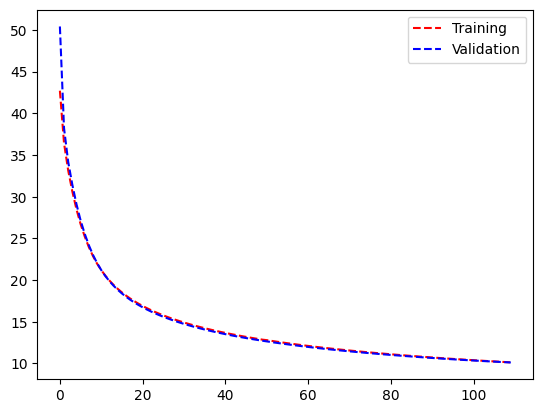

In [296]:
x_axis = range(len(loss_epoch))
plt.plot(x_axis,loss_epoch,'r--' , label="Training")
plt.plot(x_axis,loss_val, 'b--', label="Validation")
plt.legend(loc="upper right")

In [297]:
df_metrics = pd.DataFrame(data={"Training Loss": loss_epoch, "Validation Loss": loss_val})

In [298]:
df_metrics['epoch'] = df_metrics.index + 1

In [299]:
px.line(df_metrics, x='epoch',y=["Training Loss", "Validation Loss"], title="Training and Validation Loss", width=900, height=600)

In [300]:
def model_inference(context: list[str]) -> str:
    with torch.no_grad():
        x = tokenizer.encode(context)

        x = torch.tensor(x).to(device=device).unsqueeze(dim=0)

        emb = C[x]

        hs = torch.tanh(emb.view(len(x), context_size * m) @ W1 + b1)
        
        logits = hs @ W2 + b2
    return [torch.argmax(logits)]

In [305]:
context = ["it", "is", "friday", "night"]

In [306]:
tokenizer.encode(context)

[5, 96, 1871, 636]

In [307]:
model_inference(context)

[tensor(19, device='mps:0')]

In [308]:
decoder[19]

'.'